What is the difference between map, apply, apply map

* apply
    * This method defined in both Series and DataFrame
    * Accept callables only
    * apply() also works elementwise but is suited to more complex operations and aggregation.
    * DataFrame.apply() operates on entire rows or columns at a time.
    * Series.apply() operate on one element at time
* map
     * map() accepts dicts, Series, or callable
     * You can use this to perform operations on a specific column of a DataFrame as each column in a DataFrame is Series.
     * Series.map() operate on one element at time
* applymap

    * Accept callables only.
    * applymap() is elementwise for DataFrames.
    * applymap() performs better than apply().
    * applymap() operates on one element at time


# Utility Functions

In [2]:
def sclean(s):
    """
    Maccor has a custom time format. This function converts the Maccor time
    string to minutes.
    :param s: A Maccor string containing the running time of this step.
    :returns: time in minutes.
    :raises none: no exception raised
    """
    parts = s.split("d ")
    day  = int(parts[0])
    time = parts[1]
    z=sum(x * float(t) for x, t in zip([1/60, 1, 60], reversed(time.split(":"))))+day*1440
    return z

def tweak(df,u,t):
    """
    Creates a new column with the step time in minutes and drops the original
    Maccor format StepTime column.
    :param u: A string containing the UUT designator
    :param t: A string containing the specific test for that UUT
    :returns: cleaned data frame
    :raises none: no exception raised
    """
    return (df
           .assign(Stime = lambda df_:df_['StepTime'].map(sclean), UUT=u, Test= t)
           .drop('StepTime', axis=1)
           )

In [3]:
import glob
import re
import pandas as pd
import numpy as np

trans={"U01":"Vendor","U02":"FW1","U03":"FW2","U04":"LT1","U05":"LT2","U06":"LH1","U07":"LH2"}
data_files = [f for f in glob.glob("Data/*.txt")]
dfs = []
for x in data_files:
    uut = "U"+re.search('_U(.+?)_', x)[1]
    tst = trans[uut]
    df = pd.read_csv(x, skiprows=4,sep="\t", header=0, usecols=[0,1,2,4,5,7,8,9],index_col=0)
    df = tweak(df,uut,tst)
    dfs.append(df)
df = pd.concat(dfs)

Now that we have clean data, we can talk about how to analyze it.

In [4]:
dis = (df[df['Step']==4]
       .groupby(['UUT'])
       .agg({"Amp-hr":"max"})
       )
z=dict(dis.reset_index().values)

discharge = (df[df['Step']==4]
            .groupby(['UUT','Cyc#'])
            .agg({"Amp-hr":"max"})
            .reset_index()
            .query('UUT != "U06" and UUT != "U07"')
            .assign(Ah  = lambda df_:df_['Amp-hr']/df_['UUT'].map(z))
            .drop("Amp-hr",axis=1)
            .query("Ah>0.81")
            )

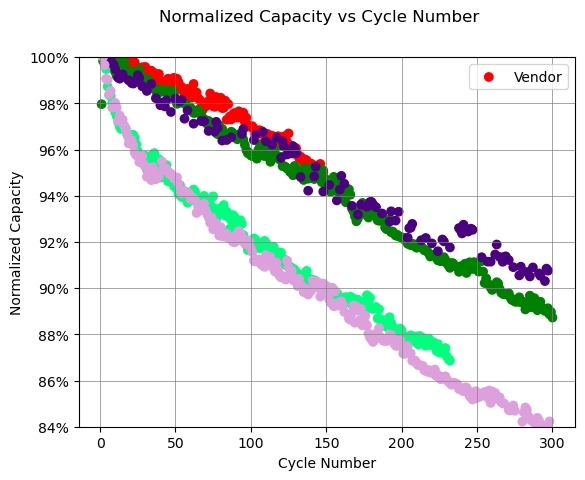

In [5]:
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import matplotlib.ticker as mtick
import numpy as np
d=discharge
fig, ax = plt.subplots()
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=0, symbol='%', is_latex=False))
colors = {'U01':'red', 'U02':'green', 'U03':'springgreen', 'U04':'indigo','U05':'plum'}
ax.set_ylim([0.84, 1])
ax.scatter(d['Cyc#'], d['Ah'], c=d['UUT'].map(colors))
ax.grid(color='grey', linestyle='-', linewidth=0.5)
fig.suptitle('Normalized Capacity vs Cycle Number', fontsize=12)
ax.set_xlabel('Cycle Number', fontsize=10)
ax.set_ylabel('Normalized Capacity', fontsize='medium')
ax.legend(labels=["Vendor","FW1.6.0-1","FW1.6.0-2","FW1.6.1-1","FW1.6.1-2"])
plt.show()

<AxesSubplot:xlabel='Cyc#'>

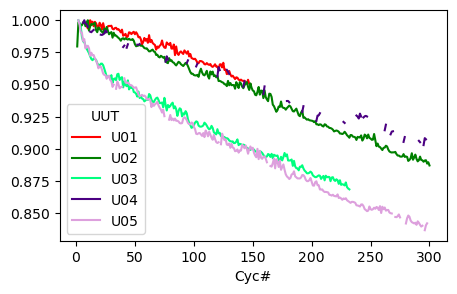

In [6]:
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import matplotlib.ticker as mtick
import numpy as np
d=discharge.pivot(index="Cyc#",columns="UUT",values="Ah")
d.plot(color=d.columns.map(colors),figsize=(5,3),kind="line")

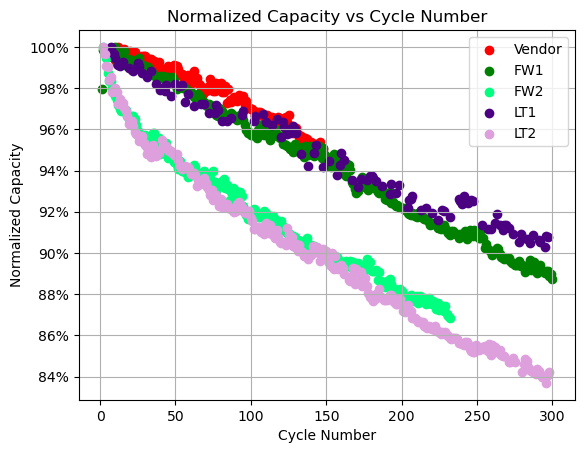

In [7]:
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import matplotlib.ticker as mtick
import numpy as np
d1=discharge

for u,c in colors.items():
    dz = discharge.query('UUT=="'+u+'"')
    plt.scatter(dz['Cyc#'],dz['Ah'],c=c,label=trans[u])

plt.title('Normalized Capacity vs Cycle Number', fontsize=12)
plt.xlabel('Cycle Number', fontsize=10)
plt.ylabel('Normalized Capacity', fontsize='medium')
plt.grid()
plt.legend()
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=0, symbol='%', is_latex=False))